# $NH_3$ Test for different $\dot{m}_L$ values

In [1]:
# Step 1: Third-party module imports
import numpy as np # Scientific computing
import matplotlib.pyplot as plt # Visualisation
# CryoEvap module imports
from cryoevap.storage_tanks import Tank
from cryoevap.cryogens import Cryogen
import time

simulation_initial_time = time.time() # Start timer for the entire simulation set

# Step 2: Initialise tank object
Q_roof = 0 		# Roof heat ingress / W
d_i = 0.201 		# Internal diameter / m
d_o = 0.204   		# External diameter / m
T_air = 298.15 		# Temperature of the environment K
U_L = 0.026 		# Liquid overall heat transfer coefficient W/m^2/K
U_V = 0.026 		# Vapour overall heat transfer coefficient W/m^2/K
Q_b = 0 		# Heat transfer rate at the bottom / W
V_tank = 6.75e-3 	# Tank volume / m^3
LF = 0.278  		# Initial liquid filling / -
P = 100000 		# Tank operating pressure / Pa


m_L_values = np.array([0, 1, 5, 10, 25]) * 1e-6  # Different mass flow rates to simulate

# Step 3: Initialise cryogen
ammonia = Cryogen(name = "ammonia") # Initialize cryogen object
ammonia.set_coolprops(P)

tanks_V_L = []  # List to store tank objects for different mass flow rates
tanks_BOG = []  # List to store boil-off gas data for different mass flow rates
tanks_Tv = []  # List to store vapour temperature data for different mass flow rates
tanks_Qv = [] # List to store vapour heat data for different mass flow rates
tanks_time = [] # List to store time data for different mass flow rates
tanks_BL = [] # List to store boil-off liquid data for different mass flow rates

all_data = []

for m_L in m_L_values:
    small_tank = Tank(d_i, d_o, V_tank, LF, m_L) # Initialize large-scale tank
    small_tank.set_HeatTransProps(U_L, U_V, T_air, Q_roof, Q_b, eta_w = 0.963)

    small_tank.cryogen = ammonia	# Set initialised cryogen as a tank property

    # Step 4: Simulation setup
    dz = 0.005 # grid spacing / m
    n_z = 1 + int(np.round(small_tank.l_V/dz, 0)) # Number of nodes
    small_tank.z_grid = np.linspace(0, 1, n_z) # Set dimensionless grid
    small_tank.U_roof = 0 # Roof overall heat transfer coefficient W/m^2/K
    evap_time = 3600*16 # Define evaporation time / s
    small_tank.time_interval = 60 # Time-step to record data
    small_tank.plot_interval = evap_time/6 # Interval to plot vapour temperature profiles

    # Tiempo de la simulación
    initial_time = time.time() # Start timer
    small_tank.evaporate(evap_time) # Simulate the evaporation
    elapsed_time = time.time() - initial_time
    current_simulation_time = time.time() - simulation_initial_time
    actual_minutes = current_simulation_time // 60
    actual_minutes_seconds = current_simulation_time % 60
    print(f"Simulation for m_L = {m_L*1e6:.1f}e-6 kg/s took {elapsed_time:.2f} seconds (Total elapsed time: {actual_minutes:.0f} minutes and {actual_minutes_seconds:.2f} seconds)")

    # Save the data from the simulation
    tanks_V_L.append(small_tank.data['V_L'])
    tanks_BOG.append(small_tank.data['BOG'])
    tanks_Tv.append(small_tank.data['Tv_avg'])
    tanks_Qv.append(small_tank.data['Q_V'])
    tanks_time.append(small_tank.data['Time'])
    tanks_BL.append(small_tank.data['B_L'])

    dict_info = small_tank.data
    all_data.append(dict_info)

# Save the results for future analysis in a txt file
for i, m_L in enumerate(m_L_values):
    filename = f'ammonia_tank_mL_{m_L*1e6:.1f}e-6_kg_per_s.txt'
    np.savetxt(filename, np.column_stack((tanks_time[i], tanks_V_L[i], tanks_BOG[i], tanks_Tv[i], tanks_Qv[i], tanks_BL[i])),
               header='Time (s), V_L (m^3), BOG (kg/s), Tv_avg (K), Q_V (W), BL (kg/s)', delimiter=', ')
    
print(dict_info)


Simulation for m_L = 0.0e-6 kg/s took 275.11 seconds (Total elapsed time: 4 minutes and 35.11 seconds)
Simulation for m_L = 1.0e-6 kg/s took 292.38 seconds (Total elapsed time: 9 minutes and 27.50 seconds)
Simulation for m_L = 5.0e-6 kg/s took 339.37 seconds (Total elapsed time: 15 minutes and 6.87 seconds)
Simulation for m_L = 10.0e-6 kg/s took 374.98 seconds (Total elapsed time: 21 minutes and 21.86 seconds)
Simulation for m_L = 25.0e-6 kg/s took 529.30 seconds (Total elapsed time: 30 minutes and 11.16 seconds)
{'Time': array([    0,    60,   120,   180,   240,   300,   360,   420,   480,
         540,   600,   660,   720,   780,   840,   900,   960,  1020,
        1080,  1140,  1200,  1260,  1320,  1380,  1440,  1500,  1560,
        1620,  1680,  1740,  1800,  1860,  1920,  1980,  2040,  2100,
        2160,  2220,  2280,  2340,  2400,  2460,  2520,  2580,  2640,
        2700,  2760,  2820,  2880,  2940,  3000,  3060,  3120,  3180,
        3240,  3300,  3360,  3420,  3480,  3540,  36

In [9]:
# Save all the dict info in a .txt file (one per mass flow rate)
for i, m_L in enumerate(m_L_values):
    filename = f'ammonia_tank_full_data_mL_{m_L*1e6:.1f}e-6_kg_per_s.txt'
    with open(filename, 'w') as f:
        headers = []
        column_info = []
        for key, value in all_data[i].items():
            headers.append(key)
            column_info.append(value)

        # column_info = np.transpose(column_info)
        header_str = ', '.join(headers)
        np.savetxt(f, column_info, header=header_str, delimiter=',')
            # f.write(f"{key}: ")
            # # The value is a list. Put all the [j] values in a single line
            # value_str = ",".join(str(v) for v in value)
            # f.write(f"{key}: {value_str}\n")  

Gráfico de la evolución del volumen del líquido en los tanques en función del tiempo para distintos flujos másicos de entrada

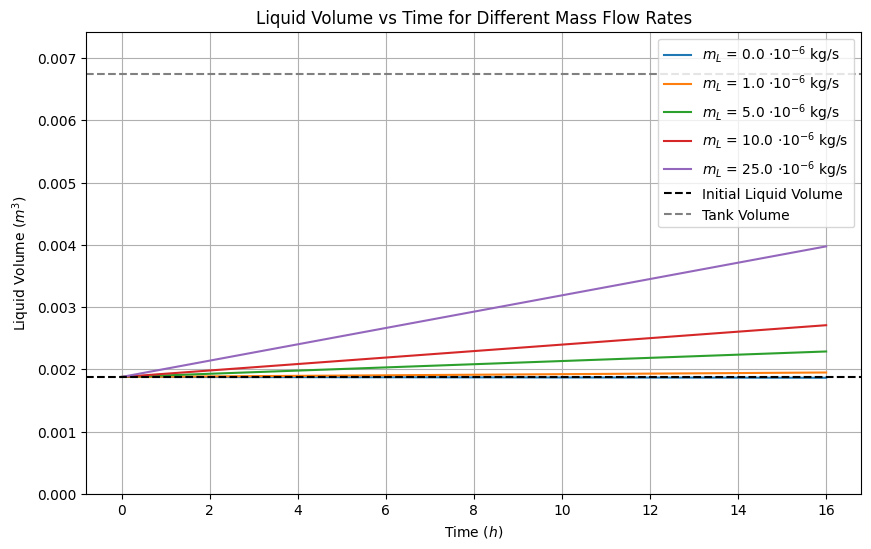

In [2]:
# Plot the V_L for different mass flow rates
plt.figure(figsize=(10, 6))
for i, m_L in enumerate(m_L_values):
    plt.plot(small_tank.data['Time']/3600, tanks_V_L[i], label=rf'$m_L$ = {m_L*1e6:.1f} $\cdot 10^{{-6}}$ kg/s')

# Plot an horizontal line for the initial liquid volume
initial_V_L = V_tank * LF
plt.axhline(y=initial_V_L, color='black', linestyle='--', label='Initial Liquid Volume')
plt.axhline(y=V_tank, color='gray', linestyle='--', label='Tank Volume')
plt.xlabel(r'Time ($h$)')
plt.ylabel(r'Liquid Volume ($m^3$)')
plt.ylim(0, V_tank*1.1)
plt.title('Liquid Volume vs Time for Different Mass Flow Rates')
plt.legend()
plt.grid(True)
plt.show()

Gráfico de la tasa de *BOG* en función del tiempo para diferentes flujos másicos de entrada

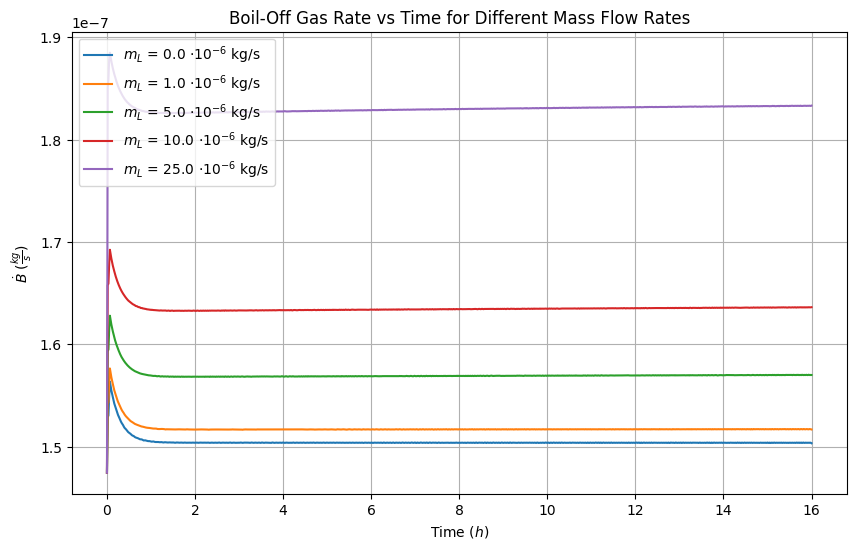

In [3]:
# Plot the BOG for different mass flow rates
plt.figure(figsize=(10, 6))
for i, m_L in enumerate(m_L_values):
    plt.plot(small_tank.data['Time']/3600, tanks_BOG[i], label=rf'$m_L$ = {m_L*1e6:.1f} $\cdot 10^{{-6}}$ kg/s')
plt.xlabel(r'Time ($h$)')
plt.ylabel(r'$\dot{B}$ ($\frac{kg}{s}$)')
plt.title('Boil-Off Gas Rate vs Time for Different Mass Flow Rates')
plt.grid(True)
plt.legend()
plt.show()

Gráfico de la temperatura media del gas en función del tiepmo para diferentes flujos másicos de entrada

In [1]:
# Plot the Tv for different mass flow rates
saturation_temp = ammonia.T_sat
print(saturation_temp)
plt.figure(figsize=(10, 6))
for i, m_L in enumerate(m_L_values):
    plt.plot(small_tank.data['Time']/3600, tanks_Tv[i], label=rf'$m_L$ = {m_L*1e6:.1f} $\cdot 10^{{-6}}$ kg/s')
plt.axhline(y=saturation_temp, color='black', linestyle='--', label='Saturation Temperature')
plt.xlabel(r'Time ($h$)')
plt.ylabel(r'Vapour Mean Temperature (K)')
plt.title('Vapour Mean Temperature vs Time for Different Mass Flow Rates')
plt.legend(loc='best')
plt.grid(True)
plt.show()

NameError: name 'ammonia' is not defined